In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random


In [5]:
df = pd.DataFrame()
for YEAR in range(1999, 2024):
    df_tmp = pd.read_csv(f'https://github.com/nflverse/nflverse-data/releases/download/pbp/play_by_play_{YEAR}.csv')
    df_tmp['year'] = YEAR
    df = pd.concat([df, df_tmp], axis=0)

/var/folders/5p/7rl6w2q54h71cb6zlvtpc8m00000gp/T/ipykernel_82968/3982721977.py:3: DtypeWarning: Columns (36,37,179,180,189,190,197,198,203,204,205,206,213,214,218,219,220,222,224,226,248,249,253,254,255,260,262,263,266,267,268,269,283,284) have mixed types. Specify dtype option on import or set low_memory=False.
  df_tmp = pd.read_csv(f'https://github.com/nflverse/nflverse-data/releases/download/pbp/play_by_play_{YEAR}.csv')
/var/folders/5p/7rl6w2q54h71cb6zlvtpc8m00000gp/T/ipykernel_82968/3982721977.py:3: DtypeWarning: Columns (37,45,179,180,182,183,189,190,193,194,197,198,203,204,205,206,218,219,220,248,249,253,254,255,260,262,263,283,284) have mixed types. Specify dtype option on import or set low_memory=False.
  df_tmp = pd.read_csv(f'https://github.com/nflverse/nflverse-data/releases/download/pbp/play_by_play_{YEAR}.csv')
/var/folders/5p/7rl6w2q54h71cb6zlvtpc8m00000gp/T/ipykernel_82968/3982721977.py:3: DtypeWarning: Columns (37,179,180,182,183,189,190,193,194,197,198,203,204,205,20

# Estimate joint distribution of winning score, losing score
- lol nvm this gave me wacky results

## Find points per drive PMF for SF + KC
- Count drive as either TD, FG, or zero
- turnovers are part of the "zero" category; we will ignore field position, pick-6 / fumble TD
- TODO: exponentially weight more recent games?

In [181]:
df['week'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22])

In [201]:
f = df['year'] == 2023
f = f & (df['posteam'] == 'SF')

df_sf = df[f]
df_sf = df_sf \
    .assign(
        drive_pts = lambda d: np.where(
            d['fixed_drive_result'] == 'Touchdown', 7, 
            np.where(d['fixed_drive_result'] == 'Field goal', 3, 0)),
        weight = lambda d: np.exp((d['week'] - 21) / 20)
            ) \
    .groupby(['game_id', 'drive']).agg({'drive_pts': max, 'weight': max}).reset_index() \
    .groupby('drive_pts').agg(sum).reset_index() \
    [['drive_pts', 'weight']] \
    .assign(freq = lambda d: d['weight'] / d['weight'].sum())

In [202]:
df_sf

,drive_pts,weight,freq
0,0,67.602963,0.546678
1,3,14.087467,0.113920
2,7,41.970888,0.339402


In [199]:
f = df['year'] == 2023
f = f & (df['posteam'] == 'KC')

df_kc = df[f]
df_kc = df_kc \
    .assign(
        drive_pts = lambda d: np.where(
            d['fixed_drive_result'] == 'Touchdown', 7, 
            np.where(d['fixed_drive_result'] == 'Field goal', 3, 0)),
        weight = lambda d: np.exp((d['week'] - 21) / 20)
            ) \
    .groupby(['game_id', 'drive']).agg({'drive_pts': max, 'weight': max}).reset_index() \
    .groupby('drive_pts').agg(sum).reset_index() \
    [['drive_pts', 'weight']] \
    .assign(freq = lambda d: d['weight'] / d['weight'].sum())

In [200]:
df_kc

,drive_pts,weight,freq
0,0,79.713370,0.600315
1,3,25.995463,0.195770
2,7,27.076977,0.203915


In [95]:
f = df['year'] == 2023
drive_pmf = df[f].groupby(['game_id']).agg({'drive': max}).assign(drive = lambda d: d['drive'] // 2).reset_index()
# drive_pmf.plot(kind='hist')
drive_pmf = drive_pmf.groupby('drive').agg('count').reset_index().assign(freq = lambda d: d['game_id'] / sum(d['game_id']))[['drive', 'freq']]
drive_pmf

,drive,freq
0,6.0,0.007042
1,7.0,0.014085
2,8.0,0.031690
3,9.0,0.123239
4,10.0,0.278169
5,11.0,0.260563
6,12.0,0.137324
7,13.0,0.080986
8,14.0,0.045775
9,15.0,0.010563


In [203]:
[p_zero, p_fg, p_td] = df_sf.sort_values('drive_pts')['freq'].tolist()
sf_pmf = [p_zero, 0, 0, p_fg, 0, 0, 0, p_td]

[p_zero, p_fg, p_td] = df_kc.sort_values('drive_pts')['freq'].tolist()
kc_pmf = [p_zero, 0, 0, p_fg, 0, 0, 0, p_td]

Text(0.5, 0, 'Score')

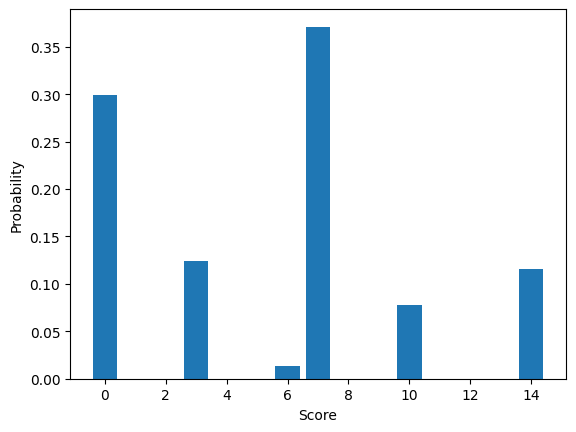

In [204]:
# What does SF's score tend to look like after two drive?
sf_pmf_2 = np.convolve(sf_pmf, sf_pmf)
plt.bar(np.arange(len(sf_pmf_2)), sf_pmf_2)
plt.ylabel('Probability')
plt.xlabel('Score')

In [71]:
def convolve_n(pmf, n):
    pmf_new = pmf
    for _ in range(n):
        pmf_new = np.convolve(pmf_new, pmf)
    return pmf_new

In [205]:
sf_pmf_10 = convolve_n(sf_pmf, 10)
kc_pmf_10 = convolve_n(kc_pmf, 10)

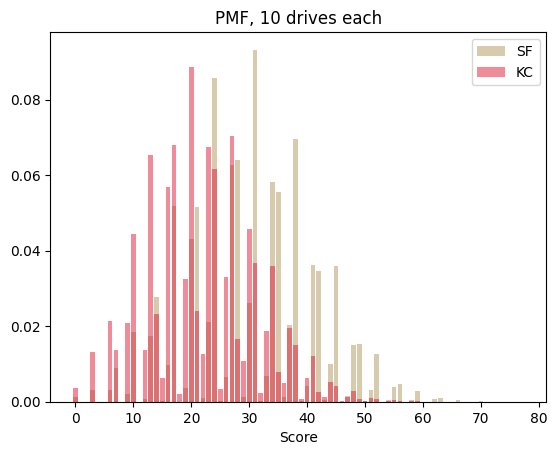

In [206]:
plt.bar(np.arange(len(sf_pmf_10)), sf_pmf_10, alpha=0.5, color='#B3995D', label='SF')
plt.bar(np.arange(len(kc_pmf_10)), kc_pmf_10, alpha=0.5, color='#E31837', label='KC')
plt.title('PMF, 10 drives each')
plt.xlabel('Score')
plt.legend();

### Central Limit Theorem side tangent lol 

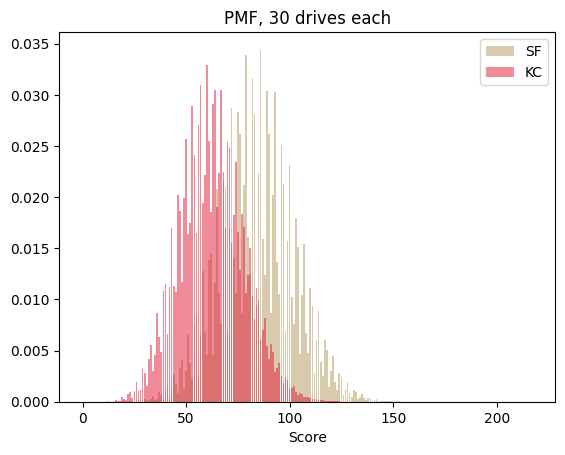

In [207]:
sf_pmf_30 = convolve_n(sf_pmf, 30)
kc_pmf_30 = convolve_n(kc_pmf, 30)

plt.bar(np.arange(len(sf_pmf_30)), sf_pmf_30, alpha=0.5, color='#B3995D', label='SF')
plt.bar(np.arange(len(kc_pmf_30)), kc_pmf_30, alpha=0.5, color='#E31837', label='KC')
plt.title('PMF, 30 drives each')
plt.xlabel('Score')
plt.legend();

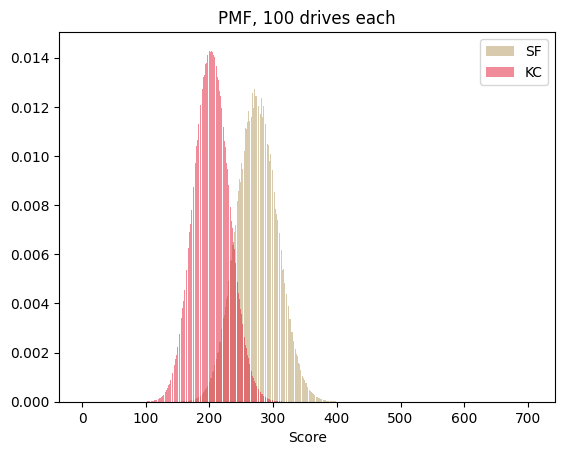

In [208]:
sf_pmf_100 = convolve_n(sf_pmf, 100)
kc_pmf_100 = convolve_n(kc_pmf, 100)

plt.bar(np.arange(len(sf_pmf_100)), sf_pmf_100, alpha=0.5, color='#B3995D', label='SF')
plt.bar(np.arange(len(kc_pmf_100)), kc_pmf_100, alpha=0.5, color='#E31837', label='KC')
plt.title('PMF, 100 drives each')
plt.xlabel('Score')
plt.legend();

## How many points do we expect each team to score given # of drives?

In [209]:
sf_pmf_n = {}
kc_pmf_n = {}
for n_drives in drive_pmf['drive']:
    n = int(n_drives)
    sf_pmf_n[n] = convolve_n(sf_pmf, n)
    kc_pmf_n[n] = convolve_n(kc_pmf, n)

### How much to add on for overtime?
- kinda rough estimation, yes ik playoff OT rules are different oh well

In [210]:
f = df['qtr'] == 5
f = f & (df['score_differential'] != df['score_differential_post'])

# df[f][['posteam', 'score_differential', 'score_differential_post']].dropna().groupby('score_differential_post').count()
ot_diff = df[f][['game_id', 'home_score', 'away_score']].groupby('game_id').agg(max).reset_index().assign(diff = lambda d: abs(d['home_score'] - d['away_score']))
ot_diff

,game_id,home_score,away_score,diff
0,1999_01_DAL_WAS,35,41,6
1,1999_04_BAL_ATL,13,19,6
2,1999_08_NYG_PHI,17,23,6
3,1999_10_MIN_CHI,24,27,3
4,1999_11_CHI_SD,20,23,3
...,...,...,...,...
406,2023_13_CIN_JAX,31,34,3
407,2023_13_IND_TEN,28,31,3
408,2023_14_LA_BAL,37,31,6
409,2023_15_HOU_TEN,16,19,3


In [211]:
ot_diff.groupby('diff').count()

,game_id,home_score,away_score
diff,,,
0,14,14,14
2,2,2,2
3,280,280,280
6,115,115,115


In [212]:
print(280 / (280 + 115))
print(115 / (280 + 115))

0.7088607594936709
0.2911392405063291


### .

In [215]:
# what is (max, min) score distribution given # of drives
N_SAMPLE = int(1e4)
score_dist_n = {}

for n_drives in drive_pmf['drive']:
    n = int(n_drives)
    score_dist_n[n] = []
    for _ in range(N_SAMPLE):
        sf_sample = random.choices(np.arange(len(sf_pmf_n[n])), sf_pmf_n[n], k=1)[0]
        kc_sample = random.choices(np.arange(len(kc_pmf_n[n])), kc_pmf_n[n], k=1)[0] 
        if sf_sample == kc_sample:
            if random.random() < 0.7:
                score_dist_n[n].append([sf_sample + 3, sf_sample])
            else:
                score_dist_n[n].append([sf_sample + 6, sf_sample])
            
        else:
            score_dist_n[n].append([max(sf_sample, kc_sample), min(sf_sample, kc_sample)])

In [217]:
score_dist = []

N_SAMPLE = int(1e6)

for _ in range(N_SAMPLE):
    # sample from drive_pmf
    n_drives = random.choices(drive_pmf['drive'], drive_pmf['freq'], k=1)[0]
    n_drives = int(n_drives)

    # sample (max, min) from corresponding drive # 
    for tup in random.choices(score_dist_n[n_drives], k=1):
        score_dist.append(tup)

In [218]:
score_heatmap = np.zeros((60, 60))
for score in score_dist:
    win_score = min(score[0], 59)
    lose_score = min(score[1], 59)
    score_heatmap[win_score, lose_score] += 1

<AxesSubplot: >

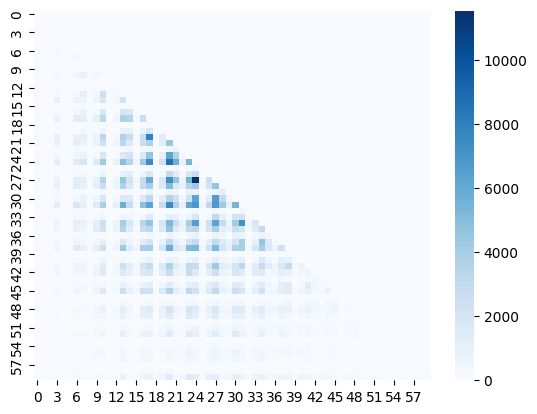

In [219]:
sns.heatmap(score_heatmap, cmap="Blues")

## How can we get the best guess to reduce MAE, given everyone else's predictions?
- aka dont play the game, play the player :P

In [60]:
# predictions
preds = [
    (31, 24),
    (21, 17),
    (24, 20),
    (26, 21),
    (34, 30),
    (27, 24),
    (20, 17),
    (50, 12),
    (17, 12),
    (34, 27),
    (30, 22),
    (25, 23),
    (34, 28),
    (27, 24),
    (38, 34),
    (27, 20),
    (24, 21),
    (31, 17),
    (32, 24),
    (30, 24),
    (29, 22),
    (35, 20),
    (31, 26)
]

In [221]:
guess = np.zeros((60, 60))

for guess_w in range(60):
    for guess_l in range(guess_w):
        count = 0

        for cell_w in range(60):
            for cell_l in range(cell_w):
                dist = abs(cell_w - guess_w) + abs(cell_l - guess_l)

                dist_other = 100
                for pred in preds:
                    dist_other = min(dist_other, abs(pred[0] - guess_w) + abs(pred[1] - guess_l))

                if dist < dist_other:
                    count += score_heatmap[cell_w, cell_l]
                elif dist == dist_other:
                    count += 0.5 * score_heatmap[cell_w, cell_l]
                else:
                    continue

        guess[guess_w, guess_l] = count



Text(0.5, 23.52222222222222, 'Losing team')

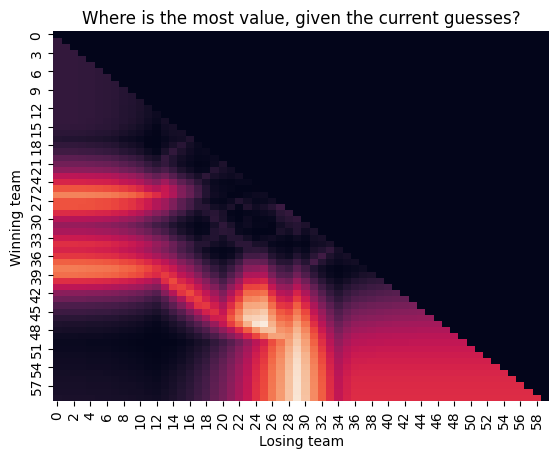

In [222]:
sns.heatmap(guess, cbar=False)
plt.title('Where is the most value, given the current guesses?')
plt.ylabel('Winning team')
plt.xlabel('Losing team')

In [223]:
# This seems very far-fetched lol
print(f'Predicted optimal score: {np.argmax(guess) // 60}, {np.argmax(guess) % 60}')


Predicted optimal score: 47, 25


# Use alternate betting odds instead

In [1]:
def odds_to_prob(odds):
    if odds[0] == '+':
        val = int(odds[1:])
        return 100 / (100 + val) 
    elif odds[0] == '-':
        val = int(odds[1:])
        return val / (100 + val)
    else:
        print("Odds must start with '-' or '+'.")

## Spread odds
![spread-odds-1](betting-odds/spread-odds-1.png)
![spread-odds-2](betting-odds/spread-odds-2.png)
![spread-odds-3](betting-odds/spread-odds-3.png)
![spread-odds-4](betting-odds/spread-odds-4.png)


In [2]:
odds_to_prob('+235')

0.29850746268656714

In [4]:
1 - odds_to_prob('-326')

0.23474178403755863

In [24]:
alt_spread_odds = {}
alt_spread_odds['-13.5'] = ('+505', '-890')
alt_spread_odds['-13'] = ('+496', '-860')
alt_spread_odds['-12.5'] = ('+457', '-770')
alt_spread_odds['-12'] = ('+445', '-740')
alt_spread_odds['-11.5'] = ('+417', '-670')
alt_spread_odds['-11'] = ('+399', '-640')
alt_spread_odds['-10.5'] = ('+370', '-573')
alt_spread_odds['-10'] = ('+355', '-543')
alt_spread_odds['-9.5'] = ('+302', '-441')
alt_spread_odds['-9'] = ('+296', '-432')
alt_spread_odds['-8.5'] = ('+293', '-425')
alt_spread_odds['-8'] = ('+283', '-407')
alt_spread_odds['-7.5'] = ('+253', '-356')
alt_spread_odds['-7'] = ('+235', '-326')

alt_spread_odds['-6.5'] = ('+194', '-262')
alt_spread_odds['-6'] = ('+181', '-243')
alt_spread_odds['-5.5'] = ('+159', '-210')
alt_spread_odds['-5'] = ('+152', '-200')
alt_spread_odds['-4.5'] = ('+141', '-185')
alt_spread_odds['-4'] = ('+134', '-175')
alt_spread_odds['-3.5'] = ('+125', '-162')
alt_spread_odds['-3'] = ('+116', '-151')
alt_spread_odds['-2.5'] = ('-103', '-125')
alt_spread_odds['-1.5'] = ('-122', '-106')
alt_spread_odds['-1'] = ('-129', '+100')

alt_spread_odds['+1'] = ('-145', '+112')
alt_spread_odds['+1.5'] = ('-153', '+118')
alt_spread_odds['+2'] = ('-162', '+125')
alt_spread_odds['+2.5'] = ('-163', '+125')
alt_spread_odds['+3'] = ('-206', '+156')
alt_spread_odds['+3.5'] = ('-231', '+174')
alt_spread_odds['+4'] = ('-254', '+189')
alt_spread_odds['+4.5'] = ('-266', '+197')
alt_spread_odds['+5'] = ('-289', '+212')
alt_spread_odds['+5.5'] = ('-299', '+218')
alt_spread_odds['+6'] = ('-343', '+246')
alt_spread_odds['+6.5'] = ('-361', '+256')

alt_spread_odds['+7'] = ('-455', '+310')
alt_spread_odds['+7.5'] = ('-488', '+327')
alt_spread_odds['+8'] = ('-536', '+353')
alt_spread_odds['+8.5'] = ('-551', '+360')
alt_spread_odds['+9'] = ('-593', '+381')
alt_spread_odds['+9.5'] = ('-600', '+385')
alt_spread_odds['+10'] = ('-720', '+440')
alt_spread_odds['+10.5'] = ('-750', '+452')
alt_spread_odds['+11'] = ('-860', '+495')
alt_spread_odds['+11.5'] = ('-880', '+504')
alt_spread_odds['+12'] = ('-970', '+535')
alt_spread_odds['+12.5'] = ('-980', '+540')
alt_spread_odds['+13'] = ('-1140', '+595')

In [25]:
alt_spread_probs = {}
for k, v in alt_spread_odds.items():
    alt_spread_probs[k] = (odds_to_prob(v[0]), 1-odds_to_prob(v[1]))

Text(0.5, 1.0, 'CMF of SF line, lower + upper bounds')

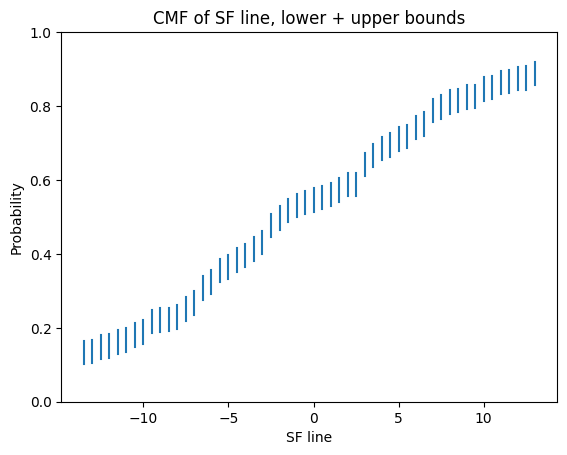

In [36]:
for k, v in alt_spread_probs.items():
    plt.axvline(x=float(k), ymin=v[1], ymax=v[0])
plt.xlabel('SF line')
plt.ylabel('Probability')
plt.title('CMF of SF line, lower + upper bounds')

In [35]:
# impute 
alt_spread_probs['-2'] = (
    np.average([
        alt_spread_probs['-2.5'][0], 
        alt_spread_probs['-1.5'][0]
        ]), 
    np.average([
        alt_spread_probs['-2.5'][1],
        alt_spread_probs['-1.5'][1],
    ])
)

alt_spread_probs['0'] = (
    np.average([
        alt_spread_probs['-1'][0], 
        alt_spread_probs['+1'][0]
        ]), 
    np.average([
        alt_spread_probs['-1'][1],
        alt_spread_probs['+1'][1],
    ])
)

alt_spread_probs['+0.5'] = (
    np.average([
        alt_spread_probs['0'][0], 
        alt_spread_probs['+1'][0]
        ]), 
    np.average([
        alt_spread_probs['0'][1],
        alt_spread_probs['+1'][1],
    ])
)

alt_spread_probs['-0.5'] = (
    np.average([
        alt_spread_probs['-1'][0], 
        alt_spread_probs['0'][0]
        ]), 
    np.average([
        alt_spread_probs['-1'][1],
        alt_spread_probs['0'][1],
    ])
)

In [77]:
spread_avg = []
for k, v in alt_spread_probs.items():
    # print(k, v)
    spread_avg.append([float(k), np.average([v[0], v[1]])])
    
spread_avg.sort(key = lambda x: x[0])
spread_avg

[[-13.5, 0.13314967860422405],
 [-13.0, 0.13597595078299773],
 [-12.5, 0.1472378711900782],
 [-12.0, 0.15126692878986459],
 [-11.5, 0.16164686377452336],
 [-11.0, 0.16776796836917074],
 [-10.5, 0.1806771837754102],
 [-10.0, 0.18765060755729496],
 [-9.5, 0.216799551227228],
 [-9.0, 0.22024758866864133],
 [-8.5, 0.22246455834242093],
 [-8.0, 0.22916763226062284],
 [-7.5, 0.25129218229710254],
 [-7.0, 0.2666246233620629],
 [-6.5, 0.30818957417221027],
 [-6.0, 0.3237085378126848],
 [-5.5, 0.35434051563083824],
 [-5.0, 0.3650793650793651],
 [-4.5, 0.3829074761592779],
 [-4.0, 0.39549339549339546],
 [-3.5, 0.41306191687871074],
 [-3.0, 0.43068466873247746],
 [-2.5, 0.4759168035030104],
 [-2.0, 0.4967050124398635],
 [-1.5, 0.5174932213767165],
 [-1.0, 0.5316593886462881],
 [-0.5, 0.5387618691705074],
 [0.0, 0.5458643496947266],
 [0.5, 0.5529668302189459],
 [1.0, 0.5600693107431651],
 [1.5, 0.5730137433368386],
 [2.0, 0.5869380831212893],
 [2.5, 0.5876637093367132],
 [3.0, 0.6412888071895425],

In [78]:
spread_avg_pdf = []
prev = 0
for elem in spread_avg:
    spread_avg_pdf.append([elem[0], elem[1] - prev])
    prev = elem[1]

spread_avg_pdf

[[-13.5, 0.13314967860422405],
 [-13.0, 0.002826272178773681],
 [-12.5, 0.011261920407080461],
 [-12.0, 0.00402905759978639],
 [-11.5, 0.010379934984658779],
 [-11.0, 0.006121104594647375],
 [-10.5, 0.01290921540623946],
 [-10.0, 0.006973423781884758],
 [-9.5, 0.029148943669933036],
 [-9.0, 0.0034480374414133375],
 [-8.5, 0.0022169696737796007],
 [-8.0, 0.006703073918201907],
 [-7.5, 0.0221245500364797],
 [-7.0, 0.015332441064960345],
 [-6.5, 0.04156495081014738],
 [-6.0, 0.015518963640474559],
 [-5.5, 0.03063197781815341],
 [-5.0, 0.010738849448526877],
 [-4.5, 0.01782811107991278],
 [-4.0, 0.012585919334117568],
 [-3.5, 0.017568521385315283],
 [-3.0, 0.017622751853766716],
 [-2.5, 0.04523213477053295],
 [-2.0, 0.02078820893685307],
 [-1.5, 0.020788208936853014],
 [-1.0, 0.01416616726957165],
 [-0.5, 0.007102480524219246],
 [0.0, 0.007102480524219246],
 [0.5, 0.007102480524219246],
 [1.0, 0.007102480524219246],
 [1.5, 0.012944432593673505],
 [2.0, 0.013924339784450623],
 [2.5, 0.00072

## Over/Under Odds
![ou-odds-1](betting-odds/ou-odds-1.png)
![ou-odds-2](betting-odds/ou-odds-2.png)
![ou-odds-3](betting-odds/ou-odds-3.png)

In [19]:
alt_ou_odds = {}
alt_ou_odds['35.5'] = ('-620', '+395')
alt_ou_odds['36'] = ('-600', '+384')
alt_ou_odds['36.5'] = ('-510', '+339')
alt_ou_odds['37'] = ('-491', '+329')
alt_ou_odds['37.5'] = ('-410', '+285')
alt_ou_odds['38'] = ('-399', '+278')
alt_ou_odds['38.5'] = ('-365', '+258')
alt_ou_odds['39'] = ('-352', '+251')
alt_ou_odds['39.5'] = ('-320', '+231')
alt_ou_odds['40'] = ('-306', '+223')
alt_ou_odds['40.5'] = ('-276', '+203')
alt_ou_odds['41'] = ('-262', '+194')
alt_ou_odds['41.5'] = ('-236', '+177')
alt_ou_odds['42'] = ('-229', '+172')
alt_ou_odds['42.5'] = ('-217', '+164')
alt_ou_odds['43'] = ('-205', '+156')
alt_ou_odds['43.5'] = ('-186', '+142')

alt_ou_odds['44'] = ('-176', '+135')
alt_ou_odds['44.5'] = ('-162', '+124')
alt_ou_odds['45'] = ('-154', '+119')
alt_ou_odds['45.5'] = ('-145', '+112')
alt_ou_odds['46'] = ('-139', '+107')
alt_ou_odds['46.5'] = ('-133', '+103')
alt_ou_odds['47'] = ('-124', '-105')
alt_ou_odds['48'] = ('-109', '-119')
alt_ou_odds['48.5'] = ('-104', '-124')
alt_ou_odds['49'] = ('+102', '-132')
alt_ou_odds['49.5'] = ('+107', '-139')
alt_ou_odds['50'] = ('+114', '-148')
alt_ou_odds['50.5'] = ('+120', '-157')
alt_ou_odds['51'] = ('+131', '-171')
alt_ou_odds['51.5'] = ('+139', '-182')
alt_ou_odds['52'] = ('+148', '-194')
alt_ou_odds['52.5'] = ('+153', '-202')

alt_ou_odds['53'] = ('+163', '-217')
alt_ou_odds['53.5'] = ('+169', '-225')
alt_ou_odds['54'] = ('+183', '-245')
alt_ou_odds['54.5'] = ('+190', '-255')
alt_ou_odds['55'] = ('+208', '-284')
alt_ou_odds['55.5'] = ('+217', '-297')
alt_ou_odds['56'] = ('+231', '-319')
alt_ou_odds['56.5'] = ('+236', '-328')
alt_ou_odds['57'] = ('+259', '-366')
alt_ou_odds['57.5'] = ('+267', '-380')
alt_ou_odds['58'] = ('+296', '-430')
alt_ou_odds['58.5'] = ('+305', '-446')
alt_ou_odds['59'] = ('+332', '-496')
alt_ou_odds['59.5'] = ('+339', '-510')
alt_ou_odds['60'] = ('+361', '-554')
alt_ou_odds['60.5'] = ('+368', '-567')

In [37]:
alt_ou_probs = {}
for k, v in alt_ou_odds.items():
    alt_ou_probs[k] = (1-odds_to_prob(v[0]), odds_to_prob(v[1]))

In [38]:
alt_ou_probs

{'35.5': (0.13888888888888884, 0.20202020202020202),
 '36': (0.1428571428571429, 0.2066115702479339),
 '36.5': (0.16393442622950816, 0.22779043280182232),
 '37': (0.16920473773265654, 0.2331002331002331),
 '37.5': (0.196078431372549, 0.2597402597402597),
 '38': (0.2004008016032064, 0.26455026455026454),
 '38.5': (0.21505376344086025, 0.27932960893854747),
 '39': (0.22123893805309736, 0.2849002849002849),
 '39.5': (0.23809523809523814, 0.3021148036253776),
 '40': (0.24630541871921185, 0.30959752321981426),
 '40.5': (0.26595744680851063, 0.33003300330033003),
 '41': (0.2762430939226519, 0.3401360544217687),
 '41.5': (0.29761904761904767, 0.36101083032490977),
 '42': (0.30395136778115506, 0.36764705882352944),
 '42.5': (0.3154574132492114, 0.3787878787878788),
 '43': (0.3278688524590164, 0.390625),
 '43.5': (0.3496503496503497, 0.4132231404958678),
 '44': (0.3623188405797102, 0.425531914893617),
 '44.5': (0.38167938931297707, 0.44642857142857145),
 '45': (0.39370078740157477, 0.4566210045

Text(0.5, 1.0, 'CDF, total score x')

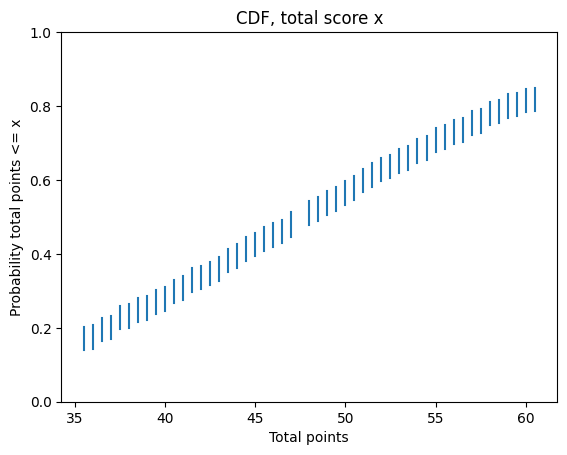

In [39]:
for k, v in alt_ou_probs.items():
    plt.axvline(x=float(k), ymin=v[0], ymax=v[1])
plt.xlabel('Total points')
plt.ylabel('Probability total points <= x')
plt.title('CDF, total score x')

In [40]:
# impute
alt_ou_probs['47.5'] = (
    np.average([
        alt_ou_probs['47'][0], 
        alt_ou_probs['48'][0]
        ]), 
    np.average([
        alt_ou_probs['47'][1],
        alt_ou_probs['48'][1],
    ])
)

## Optimize O/U

In [85]:
alt_ou_probs

{'35.5': (0.13888888888888884, 0.20202020202020202),
 '36': (0.1428571428571429, 0.2066115702479339),
 '36.5': (0.16393442622950816, 0.22779043280182232),
 '37': (0.16920473773265654, 0.2331002331002331),
 '37.5': (0.196078431372549, 0.2597402597402597),
 '38': (0.2004008016032064, 0.26455026455026454),
 '38.5': (0.21505376344086025, 0.27932960893854747),
 '39': (0.22123893805309736, 0.2849002849002849),
 '39.5': (0.23809523809523814, 0.3021148036253776),
 '40': (0.24630541871921185, 0.30959752321981426),
 '40.5': (0.26595744680851063, 0.33003300330033003),
 '41': (0.2762430939226519, 0.3401360544217687),
 '41.5': (0.29761904761904767, 0.36101083032490977),
 '42': (0.30395136778115506, 0.36764705882352944),
 '42.5': (0.3154574132492114, 0.3787878787878788),
 '43': (0.3278688524590164, 0.390625),
 '43.5': (0.3496503496503497, 0.4132231404958678),
 '44': (0.3623188405797102, 0.425531914893617),
 '44.5': (0.38167938931297707, 0.44642857142857145),
 '45': (0.39370078740157477, 0.4566210045

In [86]:
ou_avg = []
for k, v in alt_ou_probs.items():
    # print(k, v)
    ou_avg.append([float(k), np.average([v[0], v[1]])])
    
ou_avg.sort(key = lambda x: x[0])

In [87]:
ou_avg

[[35.5, 0.17045454545454541],
 [36.0, 0.17473435655253838],
 [36.5, 0.19586242951566524],
 [37.0, 0.20115248541644482],
 [37.5, 0.22790934555640435],
 [38.0, 0.23247553307673546],
 [38.5, 0.24719168618970386],
 [39.0, 0.25306961147669116],
 [39.5, 0.27010502086030785],
 [40.0, 0.27795147096951306],
 [40.5, 0.29799522505442033],
 [41.0, 0.30818957417221027],
 [41.5, 0.3293149389719787],
 [42.0, 0.33579921330234225],
 [42.5, 0.3471226460185451],
 [43.0, 0.3592469262295082],
 [43.5, 0.38143674507310876],
 [44.0, 0.3939253777366636],
 [44.5, 0.41405398037077423],
 [45.0, 0.4251608959838924],
 [45.5, 0.4399306892568348],
 [46.0, 0.4507509146403088],
 [46.5, 0.46089769339732345],
 [47.0, 0.47931184668989546],
 [47.5, 0.495117897083778],
 [48.0, 0.5109239474776606],
 [48.5, 0.5218837535014006],
 [49.0, 0.5369580061454422],
 [49.5, 0.5492490853596912],
 [50.0, 0.5647422369611095],
 [50.5, 0.5781747435443934],
 [51.0, 0.5990479385313334],
 [51.5, 0.6134900145404909],
 [52.0, 0.6283190695633092]

In [88]:
ou_avg_pdf = []
prev = 0
for elem in ou_avg:
    ou_avg_pdf.append([elem[0], elem[1] - prev])
    prev = elem[1]

ou_avg_pdf

[[35.5, 0.17045454545454541],
 [36.0, 0.004279811097992969],
 [36.5, 0.021128072963126854],
 [37.0, 0.005290055900779578],
 [37.5, 0.026756860139959537],
 [38.0, 0.004566187520331111],
 [38.5, 0.014716153112968394],
 [39.0, 0.005877925286987301],
 [39.5, 0.017035409383616695],
 [40.0, 0.007846450109205205],
 [40.5, 0.020043754084907273],
 [41.0, 0.010194349117789936],
 [41.5, 0.021125364799768453],
 [42.0, 0.006484274330363526],
 [42.5, 0.011323432716202841],
 [43.0, 0.012124280210963123],
 [43.5, 0.02218981884360055],
 [44.0, 0.012488632663554822],
 [44.5, 0.02012860263411065],
 [45.0, 0.011106915613118162],
 [45.5, 0.014769793272942422],
 [46.0, 0.010820225383473991],
 [46.5, 0.01014677875701464],
 [47.0, 0.01841415329257201],
 [47.5, 0.015806050393882554],
 [48.0, 0.015806050393882554],
 [48.5, 0.010959806023740026],
 [49.0, 0.015074252644041608],
 [49.5, 0.01229107921424899],
 [50.0, 0.015493151601418287],
 [50.5, 0.013432506583283876],
 [51.0, 0.02087319498694007],
 [51.5, 0.01444

### Uniform smoothing for lo and hi bounds

In [89]:
ou_avg_pdf.sort(key = lambda x: x[0])
[lo, lo_prob] = ou_avg_pdf[0]
ou_avg_pdf.pop(0)

lo_smooth = np.arange(25.0, lo+0.2, 0.5)
for ou in lo_smooth:
    ou_avg_pdf.append([ou, lo_prob / len(lo_smooth)])

ou_avg_pdf.sort(key = lambda x: x[0])
ou_avg_pdf

[[25.0, 0.007747933884297519],
 [25.5, 0.007747933884297519],
 [26.0, 0.007747933884297519],
 [26.5, 0.007747933884297519],
 [27.0, 0.007747933884297519],
 [27.5, 0.007747933884297519],
 [28.0, 0.007747933884297519],
 [28.5, 0.007747933884297519],
 [29.0, 0.007747933884297519],
 [29.5, 0.007747933884297519],
 [30.0, 0.007747933884297519],
 [30.5, 0.007747933884297519],
 [31.0, 0.007747933884297519],
 [31.5, 0.007747933884297519],
 [32.0, 0.007747933884297519],
 [32.5, 0.007747933884297519],
 [33.0, 0.007747933884297519],
 [33.5, 0.007747933884297519],
 [34.0, 0.007747933884297519],
 [34.5, 0.007747933884297519],
 [35.0, 0.007747933884297519],
 [35.5, 0.007747933884297519],
 [36.0, 0.004279811097992969],
 [36.5, 0.021128072963126854],
 [37.0, 0.005290055900779578],
 [37.5, 0.026756860139959537],
 [38.0, 0.004566187520331111],
 [38.5, 0.014716153112968394],
 [39.0, 0.005877925286987301],
 [39.5, 0.017035409383616695],
 [40.0, 0.007846450109205205],
 [40.5, 0.020043754084907273],
 [41.0, 

In [91]:
ou_avg_pdf.sort(key = lambda x: x[0], reverse=True)
hi = ou_avg_pdf[0][0]
hi_prob = 1 - np.asarray(ou_avg_pdf).sum(axis=0)[1]

hi_smooth = np.arange(hi+0.5, hi+10.2, 0.5)
for ou in hi_smooth:
    ou_avg_pdf.append([ou, hi_prob / len(hi_smooth)])

ou_avg_pdf.sort(key = lambda x: x[0])
ou_avg_pdf

[[25.0, 0.007747933884297519],
 [25.5, 0.007747933884297519],
 [26.0, 0.007747933884297519],
 [26.5, 0.007747933884297519],
 [27.0, 0.007747933884297519],
 [27.5, 0.007747933884297519],
 [28.0, 0.007747933884297519],
 [28.5, 0.007747933884297519],
 [29.0, 0.007747933884297519],
 [29.5, 0.007747933884297519],
 [30.0, 0.007747933884297519],
 [30.5, 0.007747933884297519],
 [31.0, 0.007747933884297519],
 [31.5, 0.007747933884297519],
 [32.0, 0.007747933884297519],
 [32.5, 0.007747933884297519],
 [33.0, 0.007747933884297519],
 [33.5, 0.007747933884297519],
 [34.0, 0.007747933884297519],
 [34.5, 0.007747933884297519],
 [35.0, 0.007747933884297519],
 [35.5, 0.007747933884297519],
 [36.0, 0.004279811097992969],
 [36.5, 0.021128072963126854],
 [37.0, 0.005290055900779578],
 [37.5, 0.026756860139959537],
 [38.0, 0.004566187520331111],
 [38.5, 0.014716153112968394],
 [39.0, 0.005877925286987301],
 [39.5, 0.017035409383616695],
 [40.0, 0.007846450109205205],
 [40.5, 0.020043754084907273],
 [41.0, 

In [92]:
ou_avg_pdf_dict = {}
for elem in ou_avg_pdf:
    ou_avg_pdf_dict[elem[0]] = elem[1]

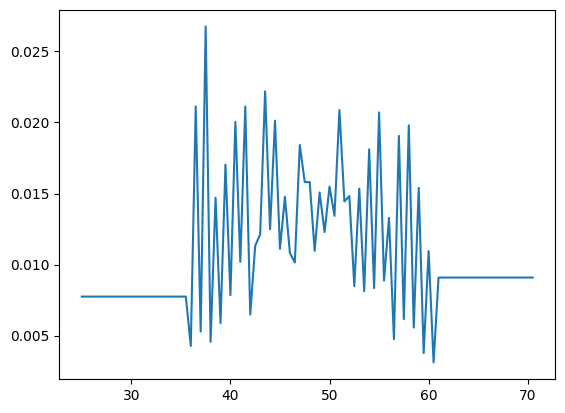

In [93]:
plt.plot(np.asarray(ou_avg_pdf)[:,0], np.asarray(ou_avg_pdf)[:,1])

In [94]:
ou_preds = [x[0] + x[1] for x in preds]

In [95]:
ou_preds

[55,
 38,
 44,
 47,
 64,
 51,
 37,
 62,
 29,
 61,
 52,
 48,
 62,
 51,
 72,
 47,
 45,
 48,
 56,
 54,
 51,
 55,
 57]

In [100]:
ou_guess = []
for guess in range(20, 75):
    p_guess = 0
    for total_ou in np.arange(25.0, 70.7, 0.5):
        dist = abs(guess - total_ou)
        dist_other = 100
        for ou_pred in ou_preds:
            dist_other = min(dist_other, abs(ou_pred - total_ou))
        if dist < dist_other:
            p_guess += ou_avg_pdf_dict[total_ou]
        elif dist == dist_other:
            p_guess += 0.5 * ou_avg_pdf_dict[total_ou]
        else:
            continue
    ou_guess.append([guess, p_guess])

Text(0.5, 1.0, 'Given other guesses in the pool, what should I guess for total score?')

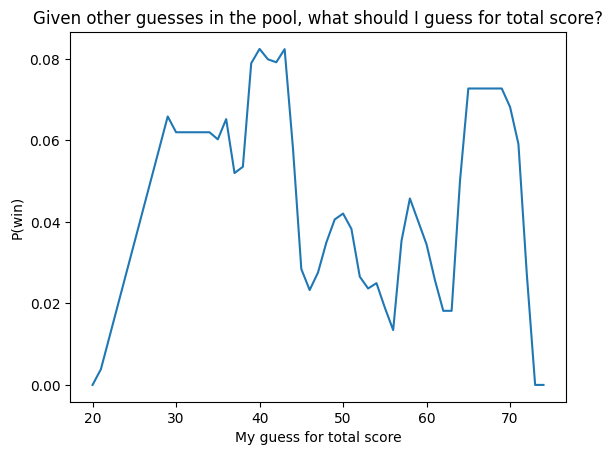

In [108]:
ou_guess.sort(key = lambda x: x[0])
plt.plot(np.asarray(ou_guess)[:, 0], np.asarray(ou_guess)[:, 1])
plt.xlabel('My guess for total score')
plt.ylabel('P(win)')
plt.title('Given other guesses in the pool, what should I guess for total score?')

In [102]:
ou_guess.sort(key = lambda x: x[1], reverse=True)

In [103]:
ou_guess

[[40, 0.08242642730396298],
 [43, 0.08236848763934179],
 [41, 0.07987361349194416],
 [42, 0.0791565402091162],
 [39, 0.07891864693887483],
 [65, 0.07272005023129476],
 [66, 0.07272005023129476],
 [67, 0.07272005023129476],
 [68, 0.07272005023129476],
 [69, 0.07272005023129476],
 [70, 0.06817504709183883],
 [29, 0.06585743801652894],
 [36, 0.06520541782749027],
 [30, 0.06198347107438016],
 [31, 0.06198347107438016],
 [32, 0.06198347107438016],
 [33, 0.06198347107438016],
 [34, 0.06198347107438016],
 [35, 0.06024940968122788],
 [71, 0.05908504081292698],
 [28, 0.058109504132231406],
 [44, 0.05802937765817695],
 [38, 0.053518544377882726],
 [37, 0.05197120170382203],
 [27, 0.05036157024793388],
 [64, 0.04999503453401515],
 [58, 0.045741282166357033],
 [26, 0.04261363636363636],
 [50, 0.04203761042933002],
 [49, 0.040591810670869755],
 [59, 0.040116899417475316],
 [51, 0.03826600419752435],
 [57, 0.035377892932860144],
 [48, 0.034968619334897866],
 [25, 0.03486570247933884],
 [60, 0.034460

In [ ]:
# O/U: 40
# SF line: -2 
# 21-19